# fxデータをランダムに推定
TODO:
trainからsigmaを推定し，testで検証

# 1. Random Walk

In [8]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def brownian_motion(N, dt, sigma):
    bm = np.zeros(N)
    x = 0
    for n in range(1, N):
        x += np.random.randn()*np.sqrt(dt)*sigma
        bm[n] = x
    return bm

In [10]:
T = 10
dt = 0.1
sigma = 1

N_bm = int(T/dt)

t = np.linspace(0, T, N_bm+1)
bm = brownian_motion(N_bm+1, dt, sigma)

In [11]:
np.std(np.diff(bm)/np.sqrt(dt))
# plt.hist(np.diff(bm))

1.0560856172558284

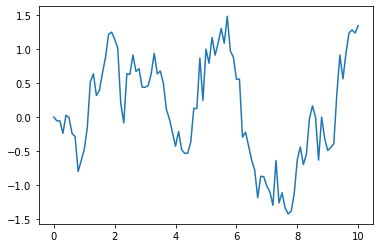

In [12]:
plt.plot(t, bm)

# 2. データを読み込み・整形


In [13]:
instrument_list = ['USD_JPY', 'GBP_JPY', 'EUR_JPY']
df_dict = {}
for instrument in instrument_list:
    df = pd.read_csv(f'data/fx_data_{instrument}', index_col=0, header=0)
    df.index = pd.to_datetime(df.index)
    df_dict[instrument] = df
df_dict['USD_JPY'].head()

,Open_ask,High_ask,Low_ask,Close_ask,Volume,Open_bid,High_bid,Low_bid,Close_bid
Time,,,,,,,,,
2014-01-01 22:00:00+00:00,105.270,105.451,104.554,104.837,76933,105.221,105.436,104.542,104.782
2014-01-02 22:00:00+00:00,104.839,104.909,104.083,104.868,64141,104.785,104.872,104.070,104.834
2014-01-05 22:00:00+00:00,104.846,104.961,103.920,104.230,78448,104.801,104.943,103.906,104.204
2014-01-06 22:00:00+00:00,104.230,104.742,104.184,104.623,66801,104.206,104.730,104.141,104.577
2014-01-07 22:00:00+00:00,104.623,105.132,104.603,104.878,74924,104.579,105.117,104.457,104.836


## 階差をとってトレンドを除去
$ \log x_t - \log x_{t-1} $

TODO: 
- データの正規化・トレンド除去関数化，逆関数も作る．

In [14]:
close_ask_arr = []
for df in df_dict.values():
    ask = np.diff(np.log(df['Close_ask'].values)) # logの階差
    close_ask_arr.append(ask)
    print(f'mean: {ask.mean()}')
    print(f'std: {ask.std()}')

mean: 2.2842877901655827e-05
std: 0.005246170114452215
mean: -0.00011480148223869543
std: 0.007317352157204696
mean: -0.00010417454370081353
std: 0.00557394828537189


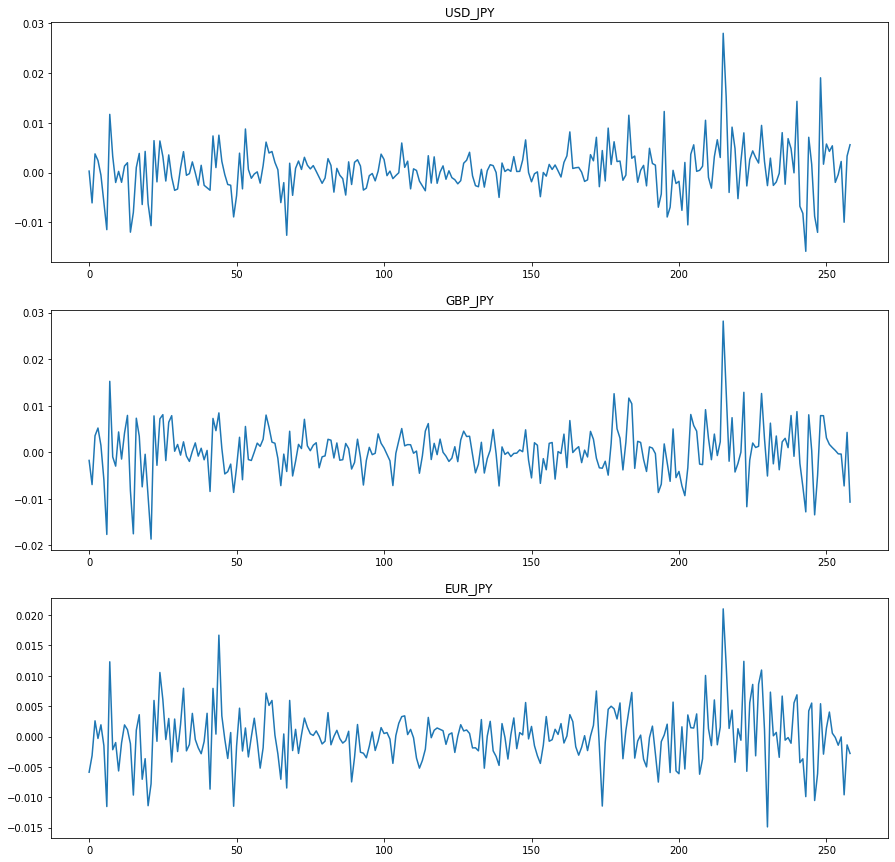

In [15]:
N = len(df['Close_ask'].values)//6
fig = plt.figure(figsize=(15, 15))
for i in range(3):
    inst = instrument_list[i]
    ax = fig.add_subplot(3, 1, i+1)
    t_index = [t.strftime('%Y-%m-%d') for t in df.index[:N]]
    ax.plot(close_ask_arr[i][:N])
    ax.set_title(inst)
#     ax.set_xticks(range(100)[::19])

# 3. ランダムな推定
各`close_ask`でmeanと　stdを元に正規乱数で推定

In [16]:
random_estimates = []
for close_ask in close_ask_arr:
    mean = close_ask.mean()
    std = close_ask.std()
    random_esti = np.random.normal(mean, std, N-1)
    random_estimates.append(random_esti)

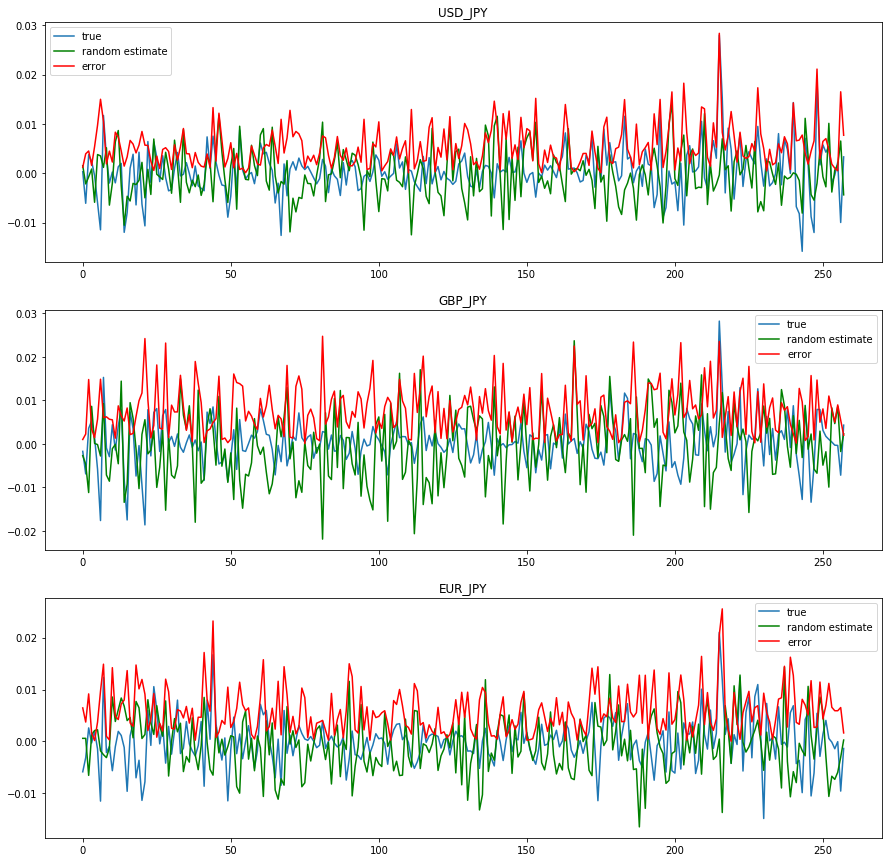

In [17]:
fig = plt.figure(figsize=(15, 15))
for i in range(3):
    inst = instrument_list[i]
    df = df_dict[inst]
    ax = fig.add_subplot(3, 1, i+1)
    t_index = [t.strftime('%Y-%m-%d') for t in df.index[:N-1]]
    ax.plot(close_ask_arr[i][:N-1], label='true')
    ax.plot(random_estimates[i], label='random estimate', color='g')
    ax.plot([norm(close_ask_arr[i][:N-1][j]-random_estimates[i][j]) for j in range(N-1)], label='error', color='r')
    ax.set_title(inst)
    plt.legend()

In [18]:
cum_random_estimates = []
for i in range(3):
    inst = instrument_list[i]
    df = df_dict[inst]
    cum_random_estimates.append(np.exp(np.cumsum([np.log(df['Close_ask'].values[0]), *random_estimates[i]])))

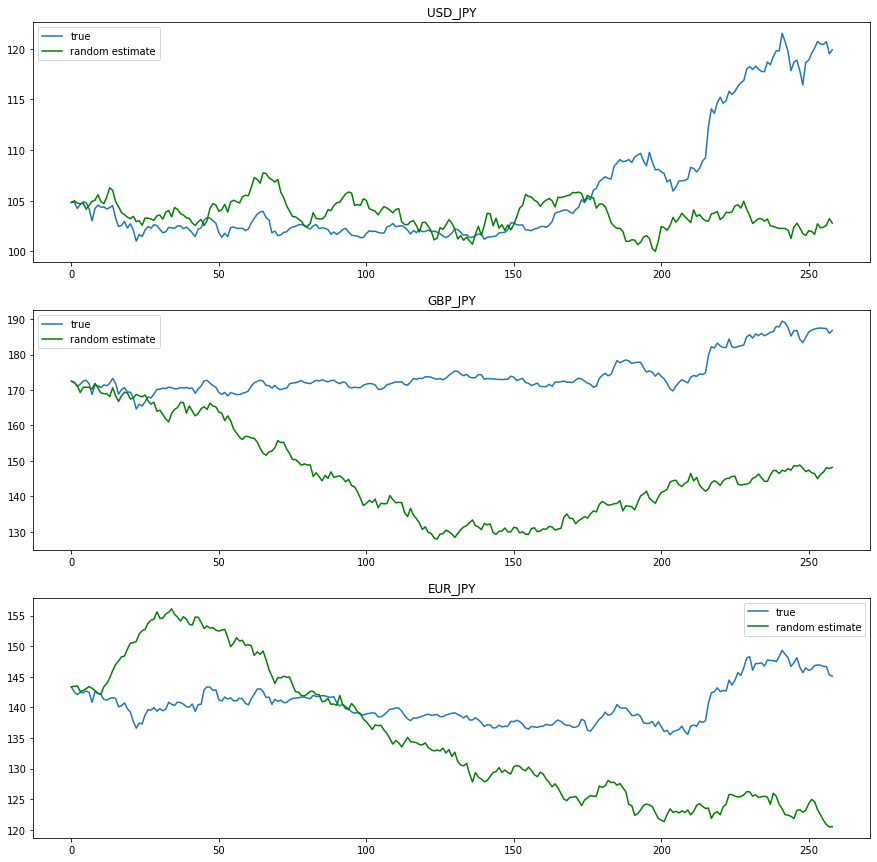

In [21]:
fig = plt.figure(figsize=(15, 15))
for i in range(3):
    inst = instrument_list[i]
    df = df_dict[inst]
    ax = fig.add_subplot(3, 1, i+1)
    t_index = [t.strftime('%Y-%m-%d') for t in df.index[:N]]
    ax.plot(df['Close_ask'][:N].values, label='true')
    ax.plot(cum_random_estimates[i], label='random estimate', color='g')
#     ax.plot([norm(df['Close_ask'][:100][j]-cum_random_estimates[i][j]) for j in range(100)], label='error')
    ax.set_title(inst)
    plt.legend()

## random estimateの誤差評価
各時刻の絶対値の平均

$ \frac{1}{N} \sum_{n=1}^N |x_n - y_n| = \frac{1}{N} \|x-y\|_{L^1}$

In [20]:
for i in range(3):
    inst = instrument_list[i]
    df = df_dict[inst]
    print(inst + ': ' + str(norm(df['Close_ask'][:N]-cum_random_estimates[i], ord=1)/N))

USD_JPY: 4.392195872551243
GBP_JPY: 28.15238483116218
EUR_JPY: 10.402020334337234
